In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [33]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
path_bucket_df = path_bucket + '/' + 'checkpoint_0512_sent_split.parquet'
runtime_path = '/home/jupyter/nlp_AI_news_anlaysis/data'

os.chdir(runtime_path)
print(os.getcwd())

/home/jupyter/nlp_AI_news_anlaysis/data


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

In [4]:
#df.to_parquet('checkpoint_0512_sent_split.parquet', index=False)
df = pd.read_parquet(path_bucket, engine='pyarrow')
df.head(3)

,url,date,language,title,text,text_split_filtered
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","[Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","[ Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament , Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot , Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the ..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interc...","[Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise, Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Interconnection Manufacturing / Product..."


## Primary Filtering: Select Relevant Titles & Text

In [5]:
# use all titles to make a word cloud
df_title = df[['title']]
df_title.head()

,title
0,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online
1,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament
2,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek"
3,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net
4,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net


### WordCloud on topics

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline

In [7]:
# remove punctuations in title
df_title['title'] = df_title['title'].str.replace('[^\w\s]','')

# only keep alphabets
df_title['title'] = df_title['title'].str.replace('[^a-zA-Z]',' ')

In [8]:
text = " ".join(title for title in df.title)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 20190116 words in the combination of all review.


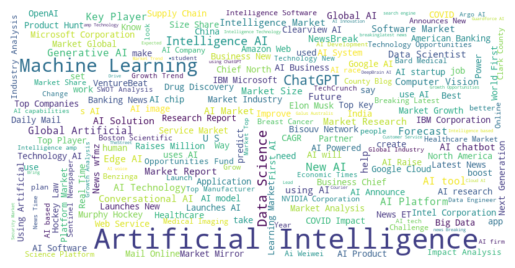

In [9]:
# ref: https://www.datacamp.com/tutorial/wordcloud-python

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way (set dpi=100)
plt.figure(dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
# Create a WordCloud object
wc = WordCloud(stopwords=stopwords, background_color="white")

# Generate the word frequencies from the text
word_frequencies = wc.process_text(text)

# Convert the word frequencies to a list of tuples
word_list = list(word_frequencies.items())

# Sort the word list by frequency
sorted_word_list = sorted(word_list, key=lambda x: x[1], reverse=True)

In [11]:
# check
print(len(sorted_word_list))
sorted_word_list[:10]

83936


[('Artificial Intelligence', 37129),
 ('Machine Learning', 12146),
 ('ChatGPT', 5696),
 ('Data Science', 5177),
 ('Intelligence AI', 4136),
 ('New AI', 3676),
 ('Key Player', 2930),
 ('Forecast', 2849),
 ('Generative AI', 2779),
 ('AI Platform', 2770)]

In [12]:
# visualze the top 100 words and frequencies using a horizontal barplot
import seaborn as sns

# create a dataframe
df_word = pd.DataFrame(sorted_word_list[:100], columns=['word', 'freq'])
df_word.head()

,word,freq
0,Artificial Intelligence,37129
1,Machine Learning,12146
2,ChatGPT,5696
3,Data Science,5177
4,Intelligence AI,4136


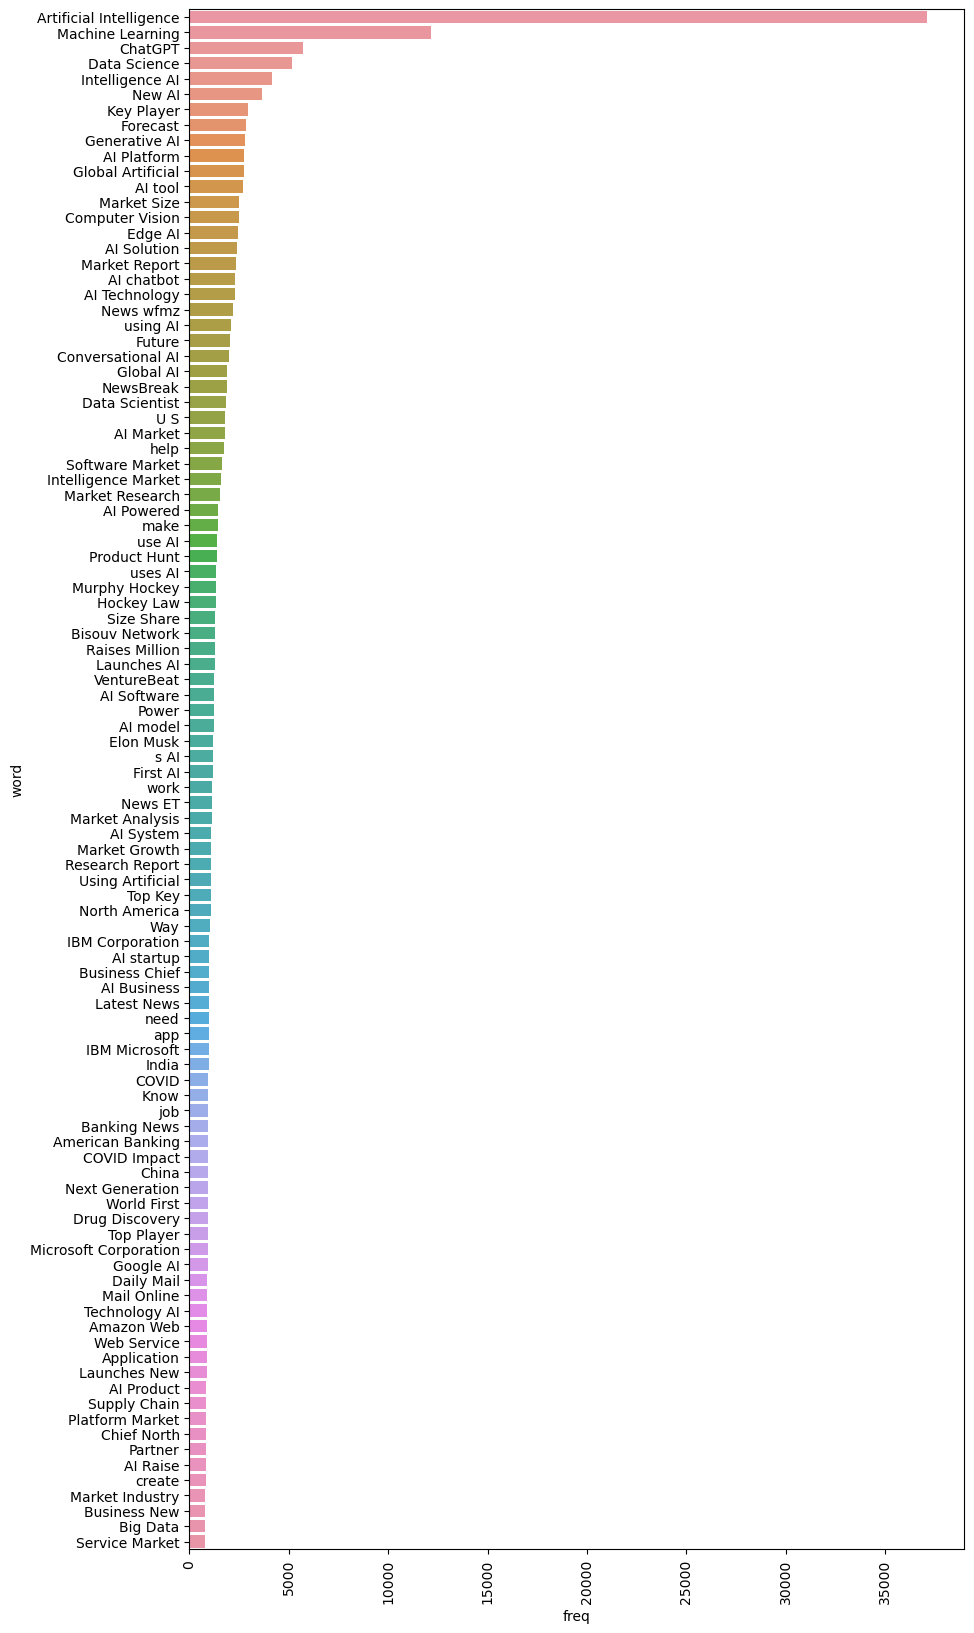

In [13]:
# plot
plt.figure(figsize=(10, 20))
sns.barplot(x='freq', y='word', data=df_word)
plt.xticks(rotation=90)
plt.show()

In [14]:
#df_word[df_word['word'] == 'Conversational AI']

### Filtering articles using title and text

In [29]:
# collect the top 22 words in the df_word; in lower cases
wc_keywords = df_word['word'].str.lower().tolist()[:15]
user_keywords = ['Big Data', 'Data Mining', 'Data Analytics', 'Data Visualization', 'Data Cleaning', 'Data Wrangling', 'Data Science', 
                 'Data Engineering', 'Data Governance', 'Data Security', 'Data Privacy', 'Data Ethics', 'Data Strategy', 'Data Operations', 
                 'Data Warehousing', 'Business Intelligence', 'Business Analytics', 'Predictive Analytics', 'Prescriptive Analytics', 
                 'Descriptive Analytics', 'Statistical Modeling', 'Machine Learning', 'Deep Learning', 'Neural Networks', 'Convolutional Neural Networks', 
                 'Recurrent Neural Networks', 'Generative Adversarial Networks', 'Natural Language Processing', 'Computer Vision', 'Image Processing', 
                 'Speech Recognition', 'Chatbots', 'Conversational AI', 'Autonomous Driving', 'Autonomous Car', 'Robotics', 'Reinforcement Learning', 'Transfer Learning', 'Model Deployment', 
                 'Model Monitoring', 'Model Interpretability', 'A/B Testing', 'Experimentation', 'Bias and Fairness in AI', 'Explainable AI', 'Human-in-the-Loop AI', 
                 'MLOps', 'CI/CD', 'Cloud Computing', 'Edge Computing', 'IoT', 'Blockchain', 'Privacy-Preserving Machine Learning', 'Federated Learning', 'Differential Privacy',
                 'Secure Multi-Party Computation', 'Homomorphic Encryption', 'Data Governance Framework', 'Data Cataloging', 'Data Lineage', 'Data Profiling', 'Data Virtualization', 
                 'Data Integration', 'Data Federation', 'Data Architecture', 'Data Modeling', 'Data Encryption', 'Data Masking', 'Data Compliance', 'Data Stewardship', 'Data Science Workflow', 
                 'Data Pipelines', 'Text Analytics', 'Text Mining', 'Sentiment Analysis', 'Speech-to-Text', 'Text-to-Speech', 'OCR', 'Object Detection', 'Semantic Segmentation', 'Predictive Maintenance', 'Recommendation Systems']

# convert to lower cases
user_keywords = [x.lower() for x in user_keywords]

# combine the two lists and convert to lower cases
filter_keywords = wc_keywords + user_keywords

In [30]:
# save filter keywords
with open('word_list.txt', 'w') as f:
    for word in filter_keywords:
        f.write(word + '\n')

In [17]:
# join the text_split_filtered back to a string
df['text_rejoined'] = df['text_split_filtered'].str.join(' ')
# change 'text_rejoined' and 'title' to str
df['text_rejoined'] = df['text_rejoined'].astype(str)
df['title'] = df['title'].astype(str)

In [5]:
# save a checkpoint
#df.to_parquet('checkpoint_0514_sent_split.parquet', index=False)
#df = pd.read_parquet('checkpoint_0514_sent_split.parquet', engine='pyarrow')

In [37]:
# with title and text_rejoined, using parallel processing and ignore case; only keep those rows that contain at least one keyword
'''#df_test = df.sample(1000)
df_selected = df[df['title'].str.contains('|'.join(filter_keywords), case=False) |
                      df['text_rejoined'].str.contains('|'.join(filter_keywords), case=False)]'''

# Using pandaraellel for faster processing
# Define the filtering function
def filter_rows(row, filter_keywords):
    for keyword in filter_keywords:
        if keyword.lower() in row['title'].lower() or keyword.lower() in row['text_rejoined'].lower():
            return True
    return False

# Apply the function in parallel
#df_test = df.sample(30)
df_selected = df[df.parallel_apply(filter_rows, args=(filter_keywords,), axis=1)]

In [38]:
# check the shape
print('initial no.of articles', len(df))
print('filtered no.of articles', len(df_selected))

# show top 5 rows
df_selected.head(2)

initial no.of articles 200332
filtered no.of articles 185454


,url,date,language,title,text,text_split_filtered,text_rejoined
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","[Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1...","Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1,..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","[ Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament , Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot , Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the ...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the nex..."


In [39]:
# check before drop
#df_selected.language.value_counts()

language
en    185454
Name: count, dtype: int64

In [40]:
# drop unwanted columns
df_selected = df_selected.drop(columns=['language', 'text'])
# rename columns
df_selected = df_selected.rename(columns={'text_rejoined': 'text', 'text_split_filtered': 'text_split'})

print(df_selected.shape)

(185454, 5)


In [41]:
df_selected.head(1)

,url,date,title,text_split,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"[Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1...","Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1,..."


In [42]:
# save a cleaned copy to bucket
path_bucket_save = path_bucket + '/' + 'df_cleaned_0514.parquet'
df_selected.to_parquet(path_bucket_save, index=False)
#df = pd.read_parquet('checkpoint_0514_sent_split.parquet', engine='pyarrow')